## 简介

HanLP中的词语提取是基于互信息与信息熵。想要计算互信息与信息熵有限要做的是 文本分词进行共性分析。在作者的原文中，有几个问题，为了便于说明，这里首先给出短语提取的原理。在文末在给出pyhanlp的调用代码。


## 共性分析

"""

    一阶共性分析，也就是词频统计
    信息=1
    先进=1
    图像=1

    二阶共性分析
    信息→算法= tf=1 mi=8.713143111007891 le=0.0 re=0.0 score=NaN
    先进→视频= tf=1 mi=6.451079180589085 le=0.0 re=0.0 score=NaN
    图像→技术= tf=1 mi=7.207932334602241 le=0.0 re=0.0 score=NaN
    图形→图像= tf=1 mi=12.339379582248355 le=0.0 re=0.0 score=NaN
    处理→方面= tf=1 mi=3.9000932023763872 le=0.0 re=0.0 score=NaN

    三阶共性分析
    信息→算法→处理= tf=1 mi=0.0 le=0.0 re=0.0
    先进→视频→处理= tf=1 mi=0.0 le=0.0 re=0.0
    图像→技术→信息= tf=1 mi=0.0 le=0.0 re=0.0

"""

互信息mi，左熵lr，右熵re,详细解释见下文

## 信息论中的互信息

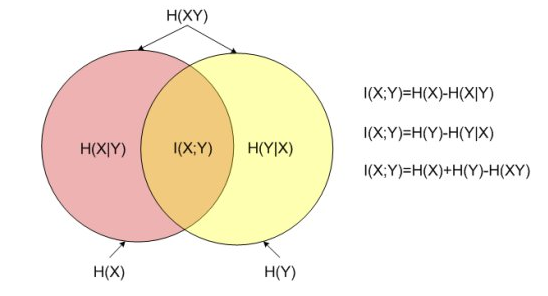
一般而言，信道中总是存在着噪声和干扰，信源发出消息x，通过信道后信宿只可能收到由于干扰作用引起的某种变形的y。信宿收到y后推测信源发出x的概率，这一过程可由后验概率p(x|y)来描述。相应地，信源发出x的概率p(x)称为先验概率。我们定义x的后验概率与先验概率比值的对数为y对x的互信息量（简称互信息）。
根据熵的连锁规则，有

        H(X,Y) = H(X) + H(Y|X) = H(Y) + H(X|Y)
        
因此，

    H(X) - H(X|Y) = H(Y) - H(Y|X)

这个差叫做X和Y的互信息，记作I(X;Y)。
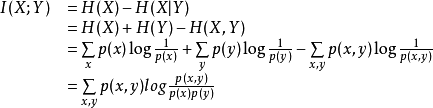


其中P(x) 为 单词x出现的次数与总单词数的比值（数学含义为单词x出现的概率）。而P（x，y）则为二阶短语x->y 出现的次数与所有二阶短语的次数。

比如在刚刚的说明中，假设默认分词方式将“后验概率”分为“后验”，“概率” 两个大短语，则后验->概率 这个二阶短语一共出现了两次，假设所有二阶短语合共有一百个，则p(后验->概率) = 2 /100 = 1/ 50。

要注意的是hanlp作者个的文章[《基于互信息和左右信息熵的短语提取识别》](http://www.hankcs.com/nlp/extraction-and-identification-of-mutual-information-about-the-phrase-based-on-information-entropy.html)中。公式与表标准定义的互信息并不一致，少乘了一个p(x,y)，查看源码发现作者确实是按照没有p(x,y)的公式进行计算的。不过使用简化公式计算似乎也是没有问题的。此处还可以参考[大鱼的一篇文章](http://www.cnblogs.com/polugen/archive/2006/11/29/576213.html)


## 信息熵

利用信息熵提取
熵这个术语表示随机变量不确定性的量度。具体表述如下: 一般地, 设X 是取有限个值的随机变量( 或者说X 是有限个离散事件的概率场) , X 取值x 的概率为P ( x ) , 则X 的熵定义为:

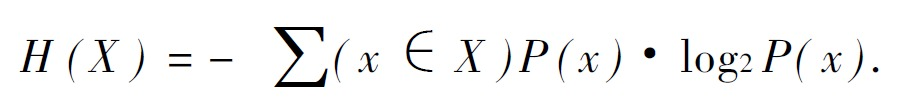

左右熵是指多字词表达的左边界的熵和右边界的熵。左右熵的公式如下:

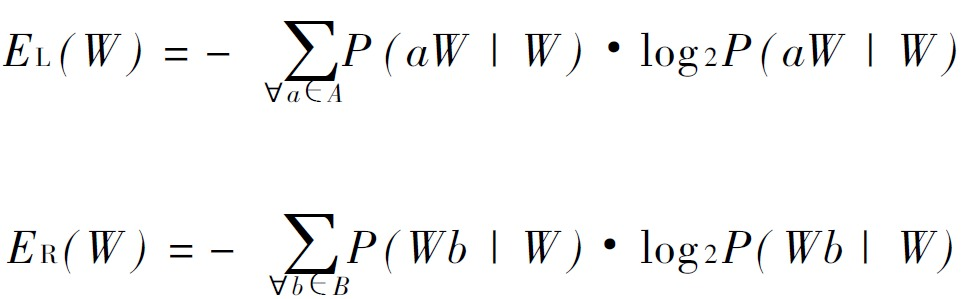

具体计算方法是，以左熵为例，对一个串左边所有可能的词以及词频，计算信息熵，然后求和。

比如算法->工程师这个二阶短语，其左边可能有很多接续，比如“从事算法工程师”和“成为算法工程师”，当其接续多了，左熵也就会更高。这个二阶短语是一个二阶短语的可能性就更大一些。

但是这里存在一个问题，贾母默认分词与停用词效果不好，可能会将“abcd”分成“a，b，c，d”然后去掉“c”这种停用词，这样“a，b，d”则可能被作为一个三阶短语发现。在HanLP中因为只能发现二阶短语，所以可能因为去掉“a，b”中的一个导致无法发现二阶短语这种情况出现，但是这只存在着理论上的可能。


## 共性分析

共性 是指 文本中词语共同出现的情况。在hanlp中如果直接调用共性分析模块不仅可以获取词频统计，还可以一同给出互信息mi，左熵lr，右熵re。以下是pyhanlp中的使用。

In [3]:
from pyhanlp import * 
# 共性分析
Occurrence = JClass("com.hankcs.hanlp.corpus.occurrence.Occurrence")
PairFrequency = JClass("com.hankcs.hanlp.corpus.occurrence.PairFrequency")
TermFrequency = JClass("com.hankcs.hanlp.corpus.occurrence.TermFrequency")
TriaFrequency = JClass("com.hankcs.hanlp.corpus.occurrence.TriaFrequency")

occurrence = Occurrence()
occurrence.addAll("在计算机音视频和图形图像技术等二维信息算法处理方面目前比较先进的视频处理算法")
occurrence.compute()

print("一阶共性分析，也就是词频统计")
unigram = occurrence.getUniGram()
for entry in unigram.iterator():
    term_frequency = entry.getValue()
    print(term_frequency)
print()

print('二阶共性分析')
bigram = occurrence.getBiGram()
for entry in bigram.iterator():
    pair_frequency = entry.getValue()
    if pair_frequency.isRight():
        print(pair_frequency)
print()

print('三阶共性分析')
trigram = occurrence.getTriGram()
for entry in trigram.iterator():
    tria_frequency = entry.getValue()
    if tria_frequency.isRight():
        print(tria_frequency)

一阶共性分析，也就是词频统计
信息=1
先进=1
图像=1
图形=1
处理=2
技术=1
方面=1
比较=1
目前=1
算法=2
视频=2
计算机=1
音=1

二阶共性分析
信息→算法= tf=1 mi=8.713143111007891 le=0.0 re=0.0 score=NaN
先进→视频= tf=1 mi=6.451079180589085 le=0.0 re=0.0 score=NaN
图像→技术= tf=1 mi=7.207932334602241 le=0.0 re=0.0 score=NaN
图形→图像= tf=1 mi=12.339379582248355 le=0.0 re=0.0 score=NaN
处理→方面= tf=1 mi=3.9000932023763872 le=0.0 re=0.0 score=NaN
处理→算法= tf=1 mi=9.104492277137243 le=0.0 re=0.0 score=NaN
技术→信息= tf=1 mi=3.8693779358135583 le=0.0 re=0.0 score=NaN
方面→目前= tf=1 mi=12.682109172098322 le=0.0 re=0.0 score=NaN
比较→先进= tf=1 mi=5.906980690246837 le=0.0 re=0.0 score=NaN
目前→比较= tf=1 mi=13.23476122866847 le=0.0 re=0.0 score=NaN
算法→处理= tf=1 mi=9.104492277137243 le=0.0 re=0.0 score=NaN
视频→图形= tf=1 mi=10.041190100727349 le=0.0 re=0.0 score=NaN
视频→处理= tf=1 mi=4.9968437492887805 le=0.0 re=0.0 score=NaN
计算机→音= tf=1 mi=10.441320189120539 le=0.0 re=0.0 score=NaN
音→视频= tf=1 mi=8.362759316806295 le=0.0 re=0.0 score=NaN

三阶共性分析
信息→算法→处理= tf=1 mi=0.0 le=0.0 re=0.0
先进→视频→处

## 短语提取

- 说明
  * 内部采用`MutualInformationEntropyPhraseExtractor`实现，用户可以直接调用`MutualInformationEntropyPhraseExtractor.extractPhrase(text, size)`。
- 算法详解
  * [《基于互信息和左右信息熵的短语提取识别》](http://www.hankcs.com/nlp/extraction-and-identification-of-mutual-information-about-the-phrase-based-on-information-entropy.html)

该功能的实现依赖于共性分析，详细内容可以查看[《基于互信息和左右信息熵的短语提取识别》](http://www.hankcs.com/nlp/extraction-and-identification-of-mutual-information-about-the-phrase-based-on-information-entropy.html)

## pyhan中的短语提取

In [4]:
# 短语提取
text = """算法工程师\n
        算法（Algorithm）是一系列解决问题的清晰指令，也就是说，能够对一定规范的输入，在有限时间内获得所要求的输出。如果一个算法有缺陷，或不适合于某个问题，执行这个算法将不会解决这个问题。不同的算法可能用不同的时间、空间或效率来完成同样的任务。一个算法的优劣可以用空间复杂度与时间复杂度来衡量。算法工程师就是利用算法处理事物的人。\n
        1职位简介\n
        算法工程师是一个非常高端的职位；\n
        专业要求：计算机、电子、通信、数学等相关专业；\n
        学历要求：本科及其以上的学历，大多数是硕士学历及其以上；\n
        语言要求：英语要求是熟练，基本上能阅读国外专业书刊；\n
        必须掌握计算机相关知识，熟练使用仿真工具MATLAB等，必须会一门编程语言。\n
        2研究方向\n
        视频算法工程师、图像处理算法工程师、音频算法工程师 通信基带算法工程师\n
        \n
        3目前国内外状况\n
        目前国内从事算法研究的工程师不少，但是高级算法工程师却很少，是一个非常紧缺的专业工程师。算法工程师根据研究领域来分主要有音频/视频算法处理、图像技术方面的二维信息算法处理和通信物理层、雷达信号处理、生物医学信号处理等领域的一维信息算法处理。\n
        在计算机音视频和图形图像技术等二维信息算法处理方面目前比较先进的视频处理算法：机器视觉成为此类算法研究的核心；另外还有2D转3D算法(2D-to-3D conversion)，去隔行算法(de-interlacing)，运动估计运动补偿算法(Motion estimation/Motion Compensation)，去噪算法(Noise Reduction)，缩放算法(scaling)，锐化处理算法(Sharpness)，超分辨率算法(Super Resolution),手势识别(gesture recognition),人脸识别(face recognition)。\n
        在通信物理层等一维信息领域目前常用的算法：无线领域的RRM、RTT，传送领域的调制解调、信道均衡、信号检测、网络优化、信号分解等。\n" +
        另外数据挖掘、互联网搜索算法也成为当今的热门方向。\n
        算法工程师逐渐往人工智能方向发展。"""
                
                
phraseList = HanLP.extractPhrase(text, 10)
print(phraseList);

[算法工程师, 算法处理, 一维信息, 算法研究, 图像技术, 信号处理, 信息算法, 处理算法, 视频算法, 通信物理]
